In [ ]:
"""
Title: RandAugment for Image Classification for Improved Robustness
Author: [Sayak Paul](https://twitter.com/RisingSayak)
Date created: 2021/03/13
Last modified: 2021/03/17
Description: RandAugment for training an image classification model with improved robustness.
"""
"""
Data augmentation is a very useful technique that can help to improve the translational
invariance of convolutional neural networks (CNN). RandAugment is a stochastic data
augmentation routine for vision data and was proposed in
[RandAugment: Practical automated data augmentation with a reduced search space](https://arxiv.org/abs/1909.13719).
It is composed of strong augmentation transforms like color jitters, Gaussian blurs,
saturations, etc. along with more traditional augmentation transforms such as
random crops.
RandAugment has two parameters:
* `n` that denotes the number of randomly selected augmentation transforms to apply
sequentially
* `m` strength of all the augmentation transforms
These parameters are tuned for a given dataset and a network architecture. The authors of
RandAugment also provide pseudocode of RandAugment in the original paper (Figure 2).
Recently, it has been a key component of works like
[Noisy Student Training](https://arxiv.org/abs/1911.04252) and
[Unsupervised Data Augmentation for Consistency Training](https://arxiv.org/abs/1904.12848).
It has been also central to the
success of [EfficientNets](https://arxiv.org/abs/1905.11946).
This example requires TensorFlow 2.4 or higher, as well as
[`imgaug`](https://imgaug.readthedocs.io/),
which can be installed using the following command:
```python
pip install imgaug
```
"""

"""
## Imports & setup
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from imgaug import augmenters as iaa
import imgaug as ia

In [ ]:
tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

"""
## Load the CIFAR10 dataset
For this example, we will be using the
[CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).
"""

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")


170498071/170498071 [==============================] - 2s 0us/step
Total training examples: 50000
Total test examples: 10000


In [ ]:
"""
## Define hyperparameters
"""

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 4
EPOCHS = 1
IMAGE_SIZE = 32

"""
## Initialize `RandAugment` object
Now, we will initialize a `RandAugment` object from the `imgaug.augmenters` module with
the parameters suggested by the RandAugment authors.
"""

rand_aug = iaa.RandAugment(n=3, m=7)


In [ ]:
def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())



In [ ]:
"""
## Create TensorFlow `Dataset` objects
Because `RandAugment` can only process NumPy arrays, it
cannot be applied directly as part of the `Dataset` object (which expects TensorFlow
tensors). To make `RandAugment` part of the dataset, we need to wrap it in a
[`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function).
A `tf.py_function` is a TensorFlow operation (which, like any other TensorFlow operation,
takes TF tensors as arguments and returns TensorFlow tensors) that is capable of running
arbitrary Python code. Naturally, this Python code can only be executed on CPU (whereas
the rest of the TensorFlow graph can be accelerated on GPU), which in some  cases can
cause significant slowdowns -- however, in this case, the `Dataset` pipeline will run
asynchronously together with the model, and doing preprocessing on CPU will remain
performant.
"""

train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

In [ ]:
"""
**Note about using `tf.py_function`**:
* As our `augment()` function is not a native TensorFlow operation chances are likely
that it can turn into an expensive operation. This is why it is much better to apply it
_after_ batching our dataset.
* `tf.py_function` is [not compatible](https://github.com/tensorflow/tensorflow/issues/38762)
with TPUs. So, if you have distributed TensorFlow training pipelines that use TPUs
you cannot use `tf.py_function`. In that case, consider switching to a multi-GPU environment,
or rewriting the contents of the function in pure TensorFlow.
"""

"""
For comparison purposes, let's also define a simple augmentation pipeline consisting of
random flips, random rotations, and random zoomings.
"""

simple_aug = tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

'\nYou are encouraged to run the above code block a couple of times to see different\nvariations.\n'

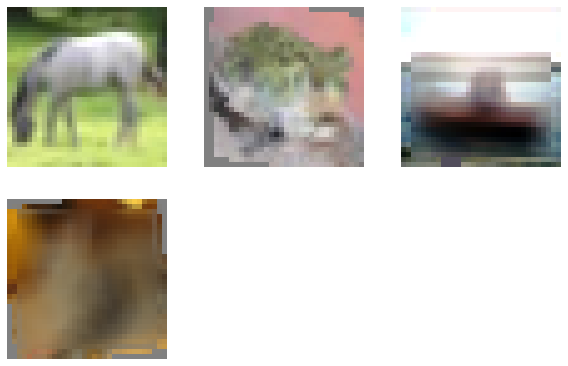

In [ ]:
"""
## Visualize the dataset augmented with RandAugment
"""

sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

"""
You are encouraged to run the above code block a couple of times to see different
variations.
"""

In [ ]:
"""
## Visualize the dataset augmented with `simple_aug`
"""

sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")


Error in callback <function flush_figures at 0x7f734a914a60> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
"""
## Define a model building utility function
Now, we define a CNN model that is based on the
[ResNet50V2 architecture](https://arxiv.org/abs/1603.05027). Also,
notice that the network already has a rescaling layer inside it. This eliminates the need
to do any separate preprocessing on our dataset and is specifically very useful for
deployment purposes.
"""


def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = tf.keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model


get_training_model().summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 10)                23585290  
                                                                 
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
"""
We will train this network on two different versions of our dataset:
* One augmented with RandAugment.
* Another one augmented with `simple_aug`.
Since RandAugment is known to enhance the robustness of models to common perturbations
and corruptions, we will also evaluate our models on the CIFAR-10-C dataset, proposed in
[Benchmarking Neural Network Robustness to Common Corruptions and Perturbations](https://arxiv.org/abs/1903.12261)
by Hendrycks et al. The CIFAR-10-C dataset
consists of 19 different image corruptions and perturbations (for example speckle noise,
fog, Gaussian blur, etc.) that too at varying severity levels. For this example we will
be using the following configuration:
[`cifar10_corrupted/saturate_5`](https://www.tensorflow.org/datasets/catalog/cifar10_corrupted#cifar10_corruptedsaturate_5).
The images from this configuration look like so:
![](https://storage.googleapis.com/tfds-data/visualization/fig/cifar10_corrupted-saturate_5-1.0.0.png)
In the interest of reproducibility, we serialize the initial random weights of our shallow
network.
"""

initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")


In [ ]:
"""
## Train model with RandAugment
"""

rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial_weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))


  202/12500 [..............................] - ETA: 1:10:39 - loss: 3.0068 - accuracy: 0.1262

In [ ]:
"""
## Train model with `simple_aug`
"""

simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial_weights.h5")
simple_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

  1/391 [..............................] - ETA: 1:47:36 - loss: 2.6099 - accuracy: 0.0781

KeyboardInterrupt: ignored

In [ ]:

"""
## Load the CIFAR-10-C dataset and evaluate performance
"""

# Load and prepare the CIFAR-10-C dataset
# (If it's not already downloaded, it takes ~10 minutes of time to download)
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", as_supervised=True)
cifar_10_c = cifar_10_c.batch(BATCH_SIZE).map(
    lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
    num_parallel_calls=AUTO,
)


KeyboardInterrupt: ignored

In [ ]:

# Evaluate `rand_aug_model`
_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

# Evaluate `simple_aug_model`
_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)


NameError: ignored